The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3

In [2]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [3]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [4]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [23]:
def load_exp_data(direc, cut=None, layer_size=20, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
    
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        summed_incoming_weights = loaded['w_r_e_summed']
        summed_incoming_weights_e_i = loaded['w_r_e_i_summed']
        
        try:
            exc_cells_initially_active = loaded['exc_raster']
            exc_cells_newly_active = None
        except KeyError as e:
            exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
            exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
            exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
            if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
        inh_raster = loaded['inh_raster']
        
        try:
            surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
        except KeyError as e:
            surviving_cell_indices = np.ones(summed_incoming_weights.shape[1], dtype=bool)
        
        first_spk_times = process_single_activation(exc_cells_initially_active, 900)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
            
        data = {
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'median_incoming_summed_weights': np.median(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
            'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
            'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
            'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
            'exc_cells_initially_active': exc_cells_initially_active,
            'exc_cells_newly_active': exc_cells_newly_active,
            'inh_raster': inh_raster,
            'freqs': loaded['freqs'][0],
            'spk_bins': loaded['spk_bins'][0],
            'surviving_cell_indices': surviving_cell_indices,
        }
        yield i_f, data

In [24]:
def make_figure_1(name, timepoints = [0, 72, 73, 74]):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    print(colors)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        scale = 1.1
        fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15 * scale, 4 * scale))
        
        timepoint_names = [f'{t * 10} rendition' for t in timepoints]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.2)
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='blue', zorder=0, alpha=1)
#                 axs[j].set_ylim(150, 1350)
#                 axs[j].set_xlim(.015 * 1000, 0.115 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
    
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')
        

## Figure 1: rasters of the chain pre-perturbation, directly post-perturbation, and recovered (with all plasticity rules in effect)

### All rules (all runs)

['#000080', '#005f06', '#0007de', '#00b8ff', '#00f6f8', '#00fa9d', '#06ff15', '#60ce00', '#7ef804', '#bbff3c', '#f6fd08', '#ffda00', '#ffba0e', '#ff4701', '#ff0a00', '#ff00f8', '#a62dff', '#eb80ee', '#f5bcf6', '#fef8fe']


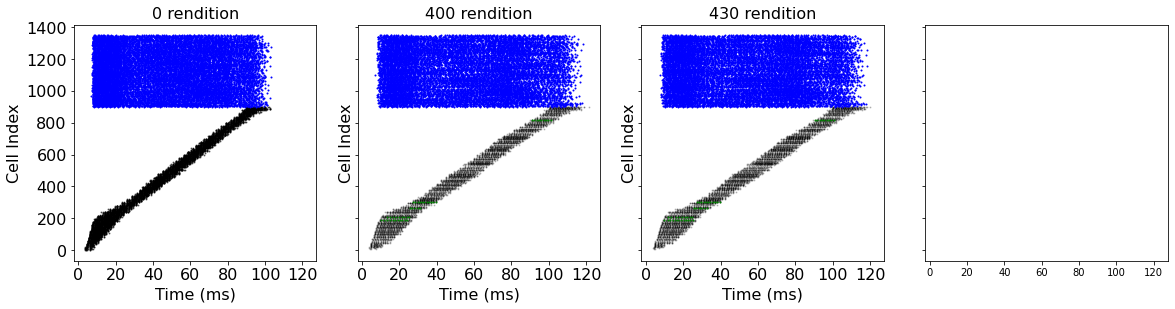

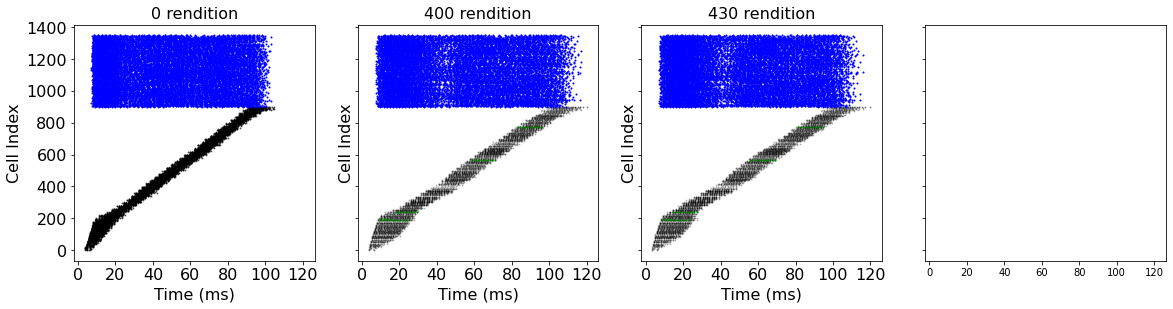

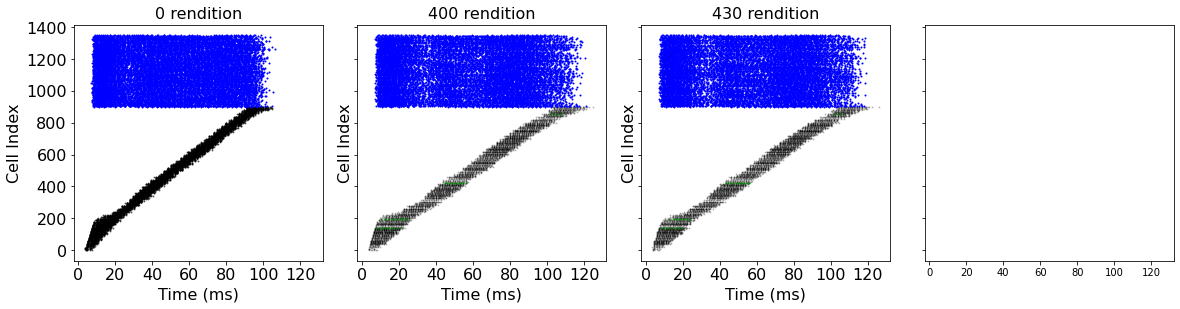

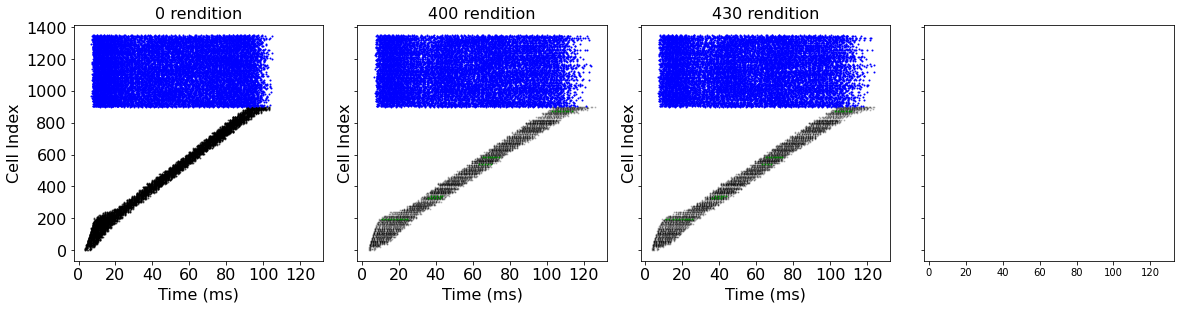

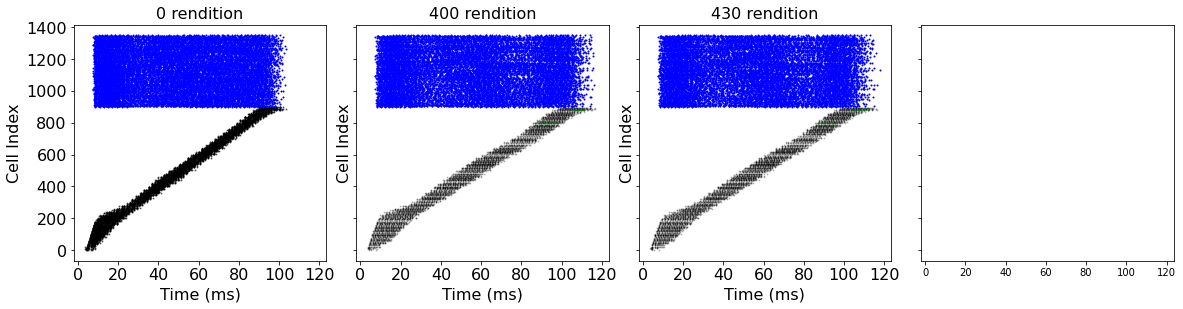

In [30]:
make_figure_1('drop', timepoints=[0, 40, 43, 270])


In [31]:
def make_figure_2_median(names, ylim=(0, 4)):
    scale = 1.4
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6.5 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    cap=170
    
    for idx, exp_dir_names in enumerate(all_dirs):
        
        all_weights_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            all_median_incoming_summed_weights = []
            baseline_median = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_median_incoming_summed_weights.append(np.median(data['summed_incoming_weights']))

                if i == 0:
                    baseline_median = np.median(data['summed_incoming_weights'])

            all_median_incoming_summed_weights = np.array(all_median_incoming_summed_weights) / baseline_median
            
            axs.plot(np.arange(cap) * 10, all_median_incoming_summed_weights, lw=0.3, color=spaced_colors[idx])
                    
            all_weights_for_dir_name.append(all_median_incoming_summed_weights)
        
        axs.plot(np.arange(cap) * 10, np.array(all_weights_for_dir_name).mean(axis=0), lw=3., color=spaced_colors[idx], label=labels[idx])
        
        axs.set_xlim(0, cap * 10)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Median summed synapse strength')
        axs.legend()
        set_font_size(axs, 16)
    
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', 'median.png')

## Figure 2: comparisons of the summed synaptic strengths per HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [32]:
def make_band(span, color, ax):
    x = np.arange(span[0], span[1])
    ax.fill_between(x, [-10000] * len(x), [10000] * len(x), color=color, alpha=0.3)

def make_figure_2_plot(names, file_name_ext='', ylim1=None, ylim2=None, cap=100, timepoints=[]):
    
    scale = 1.8
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6 * scale, 3.5 * scale))

    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#ff1717', '#ff1717', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate',
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        axs_ins = inset_axes(axs[0], width='50%', height='40%',
                        bbox_transform=axs[0].transAxes,
                        bbox_to_anchor=(.45, .1, 1, 1), loc='lower left')
        axs_ins_ei = inset_axes(axs[1], width='50%', height='40%',
                        bbox_transform=axs[1].transAxes,
                        bbox_to_anchor=(.45, .1, 1, 1), loc='lower left')
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                    all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                    all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                    all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == 0:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
            
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
        ins_points = [50, 220, 1000]
        ins_colors = ['green', 'red', 'purple']
        for j, ins_tp in enumerate(ins_points):
            for i in range(2):
                make_band((ins_tp, ins_tp+10), ins_colors[j], axs[i])
            axs_ins.bar([j], [np.array(all_weights_for_dir_name).mean(axis=0)[int(ins_tp/10)]],
                            width=0.25, color=ins_colors[j], alpha=0.55)
            axs_ins.errorbar([j],
                           [np.array(all_weights_for_dir_name).mean(axis=0)[int(ins_tp/10)]],
                           [np.array(all_weights_for_dir_name).std(axis=0)[int(ins_tp/10)]],
                            color='black', capsize=3)
            axs_ins_ei.bar([j], [np.array(all_weights_e_i_for_dir_name).mean(axis=0)[int(ins_tp/10)]],
                            width=0.25, color=ins_colors[j], alpha=0.55)
            axs_ins_ei.errorbar([j],
                           [np.array(all_weights_e_i_for_dir_name).mean(axis=0)[int(ins_tp/10)]],
                           [np.array(all_weights_e_i_for_dir_name).std(axis=0)[int(ins_tp/10)]],
                            color='black', capsize=3)
        for ax in [axs_ins, axs_ins_ei]:
            ax.set_xticks(np.arange(len(ins_points)))
            ax.set_xticklabels([f'{ip} rendition' for ip in ins_points])
        
        axs[0].fill_between(
            np.arange(cap) * 10,
            np.array(all_weights_for_dir_name).mean(axis=0) - np.array(all_weights_for_dir_name).std(axis=0),
            np.array(all_weights_for_dir_name).mean(axis=0) + np.array(all_weights_for_dir_name).std(axis=0),
            color='black', alpha=0.2, label=labels[idx])
        axs[0].plot(np.arange(cap) * 10, np.array(all_weights_for_dir_name).mean(axis=0), lw=1.5, color='black', label=labels[idx])
        axs[1].fill_between(
            np.arange(cap) * 10,
            np.array(all_weights_e_i_for_dir_name).mean(axis=0) - np.array(all_weights_e_i_for_dir_name).std(axis=0),
            np.array(all_weights_e_i_for_dir_name).mean(axis=0) + np.array(all_weights_e_i_for_dir_name).std(axis=0),
            color='blue', alpha=0.2, label=labels[idx])
        axs[1].plot(np.arange(cap) * 10, np.array(all_weights_e_i_for_dir_name).mean(axis=0), lw=1.5, color='blue', label=labels[idx])


        axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
        for i in range(2):
            axs[i].set_xlim(0, (cap - 1) * 10)
            axs[i].set_xlabel('Rendition number')
            axs[i].tick_params(right=True, labelright=True)
    #         axs.legend()
            set_font_size(axs[i], 16)
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


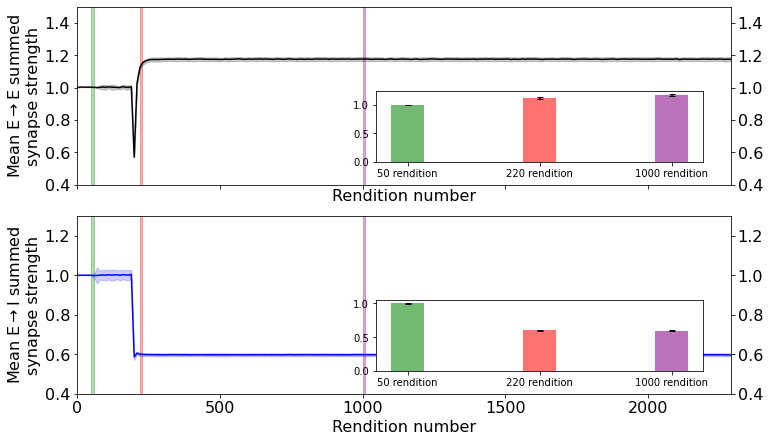

In [44]:
make_figure_2_plot([
    'drop',
], ylim1=(0.4, 1.5), ylim2=(0.4, 1.3), cap=230)

In [13]:
def make_figure_2_plot_median(names, file_name_ext='', ylim=(0, 2), cap=100, timepoints=[]):
    
    scale = 1.8
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7.5 * scale, 5 * scale))

    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#ff1717', '#ff1717', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate',
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        for j, exp_dir_name in enumerate(exp_dir_names):
        #     axs_ins = inset_axes(axs[0], width='50%', height='40%',
        #                 bbox_transform=axs[0].transAxes,
        #                 bbox_to_anchor=(.45, .05, 1, 1), loc='lower left')
            all_median_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_median_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_median = None
            baseline_std = None
            baseline_median_e_i = None
            baseline_std_e_i = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_median_incoming_summed_weights.append(data['median_incoming_summed_weights'])
                    all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                    all_median_incoming_summed_weights_e_i.append(data['median_incoming_summed_weights_e_i'])
                    all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == 0:
                    baseline_median = data['median_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_median_e_i = data['median_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_median_incoming_summed_weights = np.array(all_median_incoming_summed_weights) / baseline_median
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_median
            all_median_incoming_summed_weights_e_i = np.array(all_median_incoming_summed_weights_e_i) / baseline_median_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_median_e_i

            axs[0].plot(np.arange(len(all_median_incoming_summed_weights)) * 10, all_median_incoming_summed_weights, lw=1, color=colors[j])
            
#             axs_ins.scatter(np.array(timepoints) * 10 + np.random.normal(0, 1, size=len(timepoints)), all_mean_incoming_summed_weights[timepoints],
#                             s=30, edgecolor=spaced_colors[idx], facecolor='none', alpha=0.5, marker='o')
                
            all_weights_for_dir_name.append(all_median_incoming_summed_weights)
            
            axs[1].plot(np.arange(len(all_median_incoming_summed_weights_e_i)) * 10, all_median_incoming_summed_weights_e_i, lw=1, color=colors[j])
        
        # axs[0].plot(np.arange(cap) * 10, np.array(all_weights_for_dir_name).mean(axis=0), lw=3., color=spaced_colors[idx], label=labels[idx])
        
            for i in range(2):
                axs[i].set_xlim(0, (cap - 1) * 10)
                axs[i].set_ylim(ylim[0], ylim[1])
                axs[i].set_xlabel('Network activations')
                axs[i].set_ylabel('Median summed synapse strength')
                axs[i].tick_params(right=True, labelright=True)
        #         axs.legend()
                set_font_size(axs[i], 16)
            
            fig.tight_layout()
            save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')


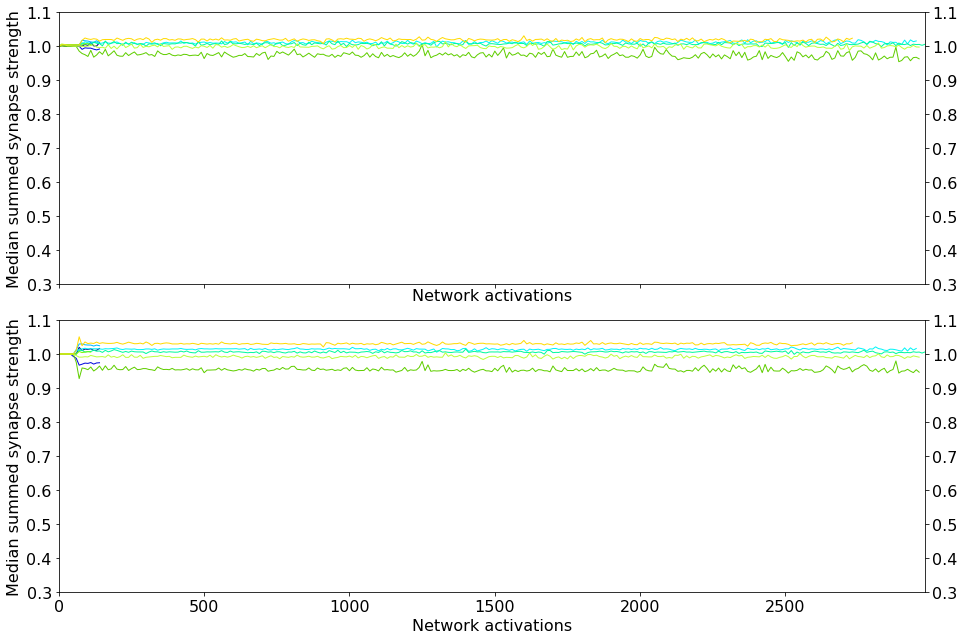

In [14]:
make_figure_2_plot_median([
    'drop',
], ylim=(0.3, 1.1), cap=299)

In [34]:
def make_figure_3(names, ylim=(0, 8), trials=[0], timepoints=[]):    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#1f22ff', 'black', '#ff1f71', '#ff1f71']
    labels = [
        'unperturbed',
        'perturbed',
        '100th rendition',
        '1900th rendition',
    ]
    
    for i_t in trials:
        scale = 1.1
        fig = plt.figure(constrained_layout=True, figsize=(18 * scale, 10 * scale))
        gs = gridspec.GridSpec(ncols=3, nrows=6, figure=fig)

        col_1_axs = [fig.add_subplot(gs[i:(i+2), 1]) for i in range(0, 6, 2)]
        col_2_axs = [fig.add_subplot(gs[i:(i+2), 2]) for i in range(0, 6, 2)]
        
        axs = [
            [fig.add_subplot(gs[0:3, 0])],
            [fig.add_subplot(gs[3:, 0])],
            col_1_axs,
            col_2_axs,
        ]
        
        for idx, exp_dir_names in enumerate(all_dirs):
            j = 0
            spk_bins_zero = None
            freqs_zero = None
            exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
                if j < len(timepoints) and i == timepoints[j]:
 
                    if j >= 2 or (j == 1 and idx == 0):
                        if idx == 0:
                            axs[j][idx].plot(spk_bins_zero, freqs_zero, color=spaced_colors[0], alpha=0.2, zorder=-j, label=labels[0])
                        else:
                            axs[j][idx].plot(spk_bins_zero, freqs_zero, color=spaced_colors[0], alpha=0.2, zorder=-j)

                    spk_bins = data['spk_bins']
                    freqs = data['freqs']
                    if j == 0:
                        spk_bins_zero = spk_bins
                        freqs_zero = freqs

                    if j >= 2 or (j < 2 and idx == 0):
                        if idx == 0:
                            axs[j][idx].plot(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j, label=labels[j])
                        else:
                            axs[j][idx].plot(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j)
                        axs[j][idx].set_ylabel('Number neurons')
                        if idx == (len(all_dirs) - 1):
                            axs[j][idx].set_xlabel('Spikes per neuron')
                        axs[j][idx].set_xlim(-0.5, 20)
                        axs[j][idx].set_ylim(0, 500)
                        
                        if idx == 0:
                            axs[j][idx].legend()

                        set_font_size(axs[j][idx], 18)
                    j += 1
        plt.locator_params(axis='x', nbins=5)
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_3', f'trial_{i_t}.png')

## Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

### First run only

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


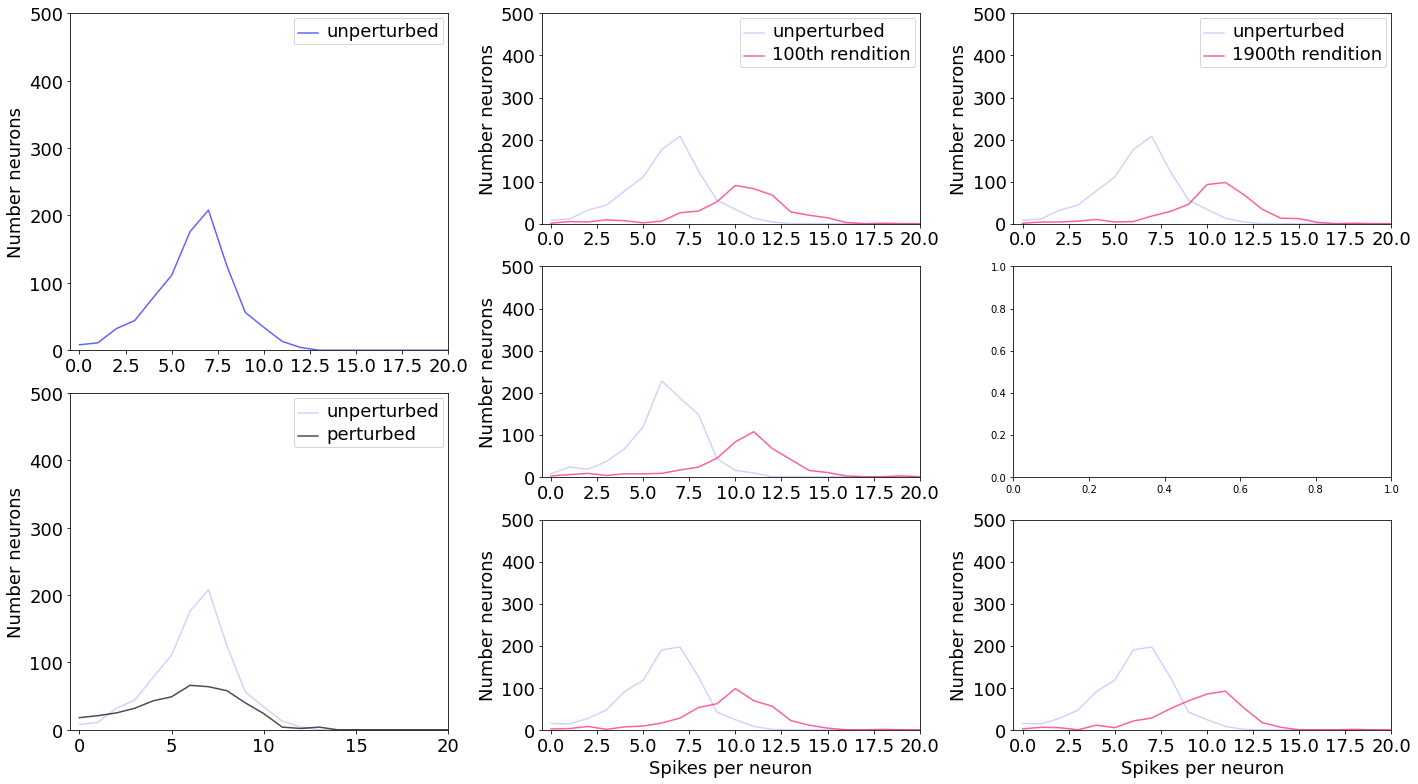

In [36]:
make_figure_3([
    'drop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-08-12--05:41--28:0845',
    'drop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-08-12--05:41--28:1354',
    'drop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-08-12--05:41--28:1377'
], timepoints=[0, 20, 25, 230])

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

In [40]:
def make_figure_4_averaged(names, dropout=0, file_name_ext='', ylim=(0, 8), cap=100):
    scale = 1.4
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(10 * scale, 12 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(20) * i for i in range(0, 900, 20)])
    spaced_colors = ['#ff1717', '#d117ff', '#171bff']
    labels = [
        'BTDP + single-cell firing rate',
        'BTDP + single-cell firing rate \n+ population-level firing rate',
        'BTDP + population-level firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        to_plot = ['pop_firing_rates', 'inh_pop_firing_rates', 'relative_prop_speeds', 'r_squareds', 'last_layer_actives']
        
        plot_data = {}
        for var in to_plot:
            plot_data[var] = {'raw': []}
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            
            for var in to_plot:
                plot_data[var]['raw'].append([])

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                plot_data['pop_firing_rates']['raw'][-1].append(pop_firing_rate)
                
                inh_pop_firing_rate = np.sum(data['inh_raster'])
                plot_data['inh_pop_firing_rates']['raw'][-1].append(inh_pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(x_firing, first_spk_times_nonnan)
                plot_data['relative_prop_speeds']['raw'][-1].append(res.slope)
                plot_data['r_squareds']['raw'][-1].append(np.square(res.rvalue))
                plot_data['last_layer_actives']['raw'][-1].append(data['last_layer_active'])
                
        for var in to_plot:
            l = len(plot_data[var]['raw'])
            plot_data[var]['raw'] = np.stack(plot_data[var]['raw'])
            plot_data[var]['means'] = plot_data[var]['raw'].mean(axis=0)
            plot_data[var]['stds'] = plot_data[var]['raw'].std(axis=0)
            
        epochs = np.arange(0, cap * 10, 10)
        
        axs[0].fill_between(
            epochs,
            plot_data['pop_firing_rates']['means'] - plot_data['pop_firing_rates']['stds'],
            plot_data['pop_firing_rates']['means'] + plot_data['pop_firing_rates']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0].plot(epochs, plot_data['pop_firing_rates']['means'], c=spaced_colors[idx], lw=1., label=labels[idx])
        axs[0].fill_between(
            epochs,
            plot_data['inh_pop_firing_rates']['means'] - plot_data['inh_pop_firing_rates']['stds'],
            plot_data['inh_pop_firing_rates']['means'] + plot_data['inh_pop_firing_rates']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0].plot(epochs, plot_data['inh_pop_firing_rates']['means'], '--', c=spaced_colors[idx], lw=1., label=f'{labels[idx]} inh', )
        axs[1].fill_between(
            epochs,
            plot_data['relative_prop_speeds']['means'] - plot_data['relative_prop_speeds']['stds'],
            plot_data['relative_prop_speeds']['means'] + plot_data['relative_prop_speeds']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[1].plot(epochs, plot_data['relative_prop_speeds']['means'], c=spaced_colors[idx], lw=1.)
        axs[2].fill_between(
            epochs,
            plot_data['r_squareds']['means'] - plot_data['r_squareds']['stds'],
            plot_data['r_squareds']['means'] + plot_data['r_squareds']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[2].plot(epochs, plot_data['r_squareds']['means'],c=spaced_colors[idx], lw=1.)
        axs[3].fill_between(
            epochs,
            plot_data['last_layer_actives']['means'] - plot_data['last_layer_actives']['stds'],
            plot_data['last_layer_actives']['means'] + plot_data['last_layer_actives']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[3].plot(epochs, plot_data['last_layer_actives']['means'], c=spaced_colors[idx], lw=1.)
        
    axs[0].set_ylabel('Population spikes\nper activation')
    axs[1].set_ylabel('Propagation speed')
    axs[2].set_ylabel(r'$R^2$')
    axs[3].set_ylabel('Last layer active')
    
    axs[1].set_ylim(0)
    axs[2].set_ylim(0.5, 1.)
    axs[3].set_ylim(0, 45)
    
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for i in range(4):
        axs[i].set_xlim(0, cap * 10)
        axs[i].set_xlabel('Epochs')
        set_font_size(axs[i], 16)
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_4', f'dropout_{int(50 + dropout * 10)}_{file_name_ext}.png')

## Figure 4: metrics of dynamics

### 50% dropout of HVC(RA) projectors

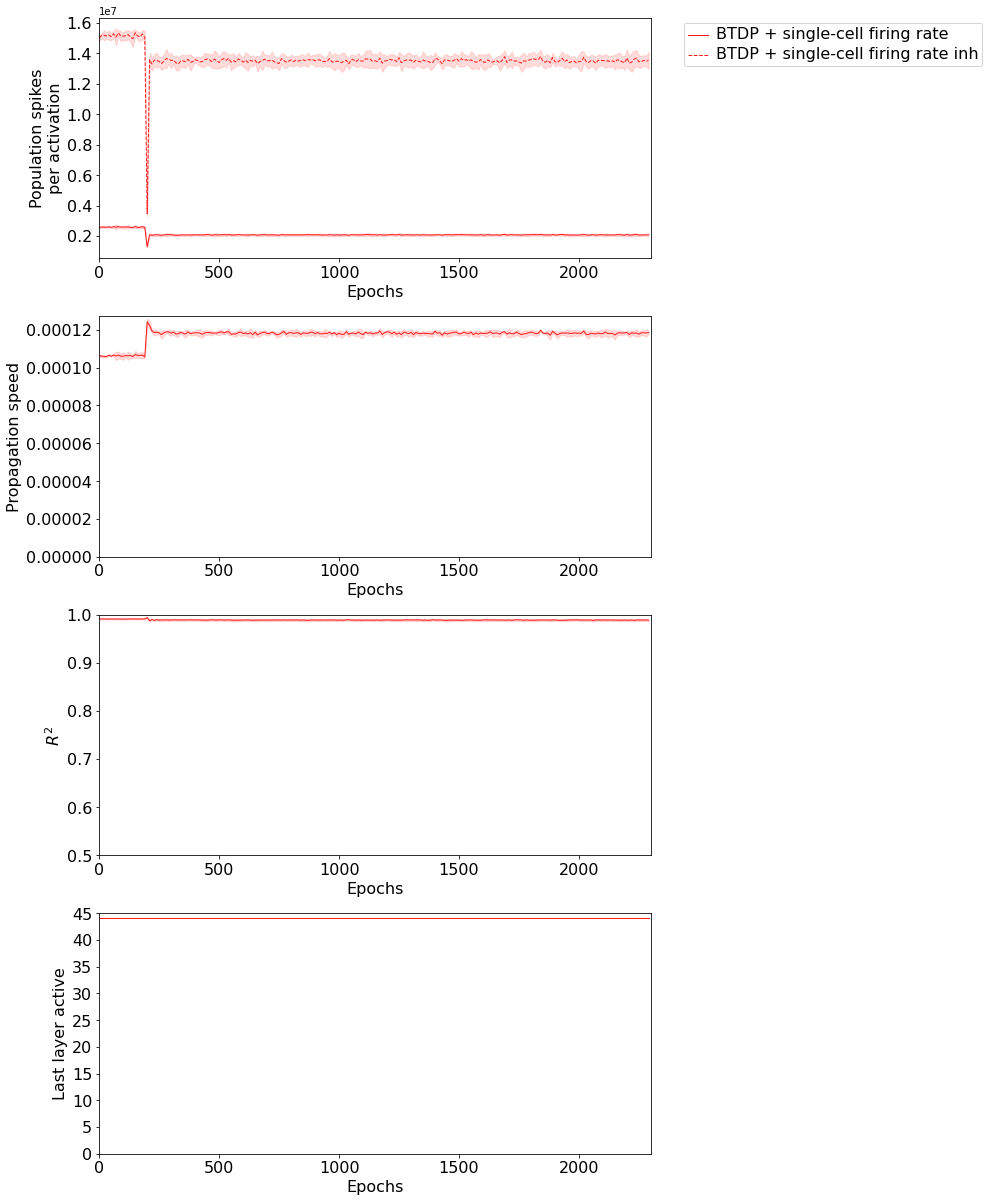

In [41]:
make_figure_4_averaged([
    'drop'
],
file_name_ext='both_rules', cap=230)

In [16]:
def make_figure_5(name, timepoints=[0, 50, 100, 150], color='black'):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        scale = 1.1
        fig, axs = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(15 * scale, 7.5 * scale))
        
        timepoint_names = [f'Rendition {t * 10}' for t in timepoints]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                summed_incoming_weights = data['summed_incoming_weights'].reshape(data['summed_incoming_weights'].shape[1])
                layer_weights = np.array([np.sum(summed_incoming_weights[i:i+20]) for i in range(0, summed_incoming_weights.shape[0], 20)])
                x = np.arange(summed_incoming_weights.shape[0])
                
                axs[0, j].scatter(x, summed_incoming_weights, s=1, c=color, zorder=0, alpha=1)
                axs[0, j].set_xlim(-1, 901)
                axs[0, j].set_xlabel('Cell Index')
                axs[0, j].set_ylabel('Summed Incoming Weights')
                axs[0, j].title.set_text(f'{timepoint_names[j]}')
                
                summed_incoming_weights_ei = data['summed_incoming_weights_e_i'].reshape(data['summed_incoming_weights_e_i'].shape[1])
                x_ei = np.arange(summed_incoming_weights_ei.shape[0])
                axs[1, j].scatter(x_ei, summed_incoming_weights_ei, s=1, c=color, zorder=0, alpha=1)

                axs[1, j].set_xlim(-1, 401)
                axs[1, j].set_xlabel('Cell Index')
                axs[1, j].set_ylabel('Summed Incoming Weights E->I')
                axs[1, j].title.set_text(f'{timepoint_names[j]}')
                
                for idx in range(2):
                    set_font_size(axs[idx, j], 16)
                j += 1
    
        fig.tight_layout()
#         save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')

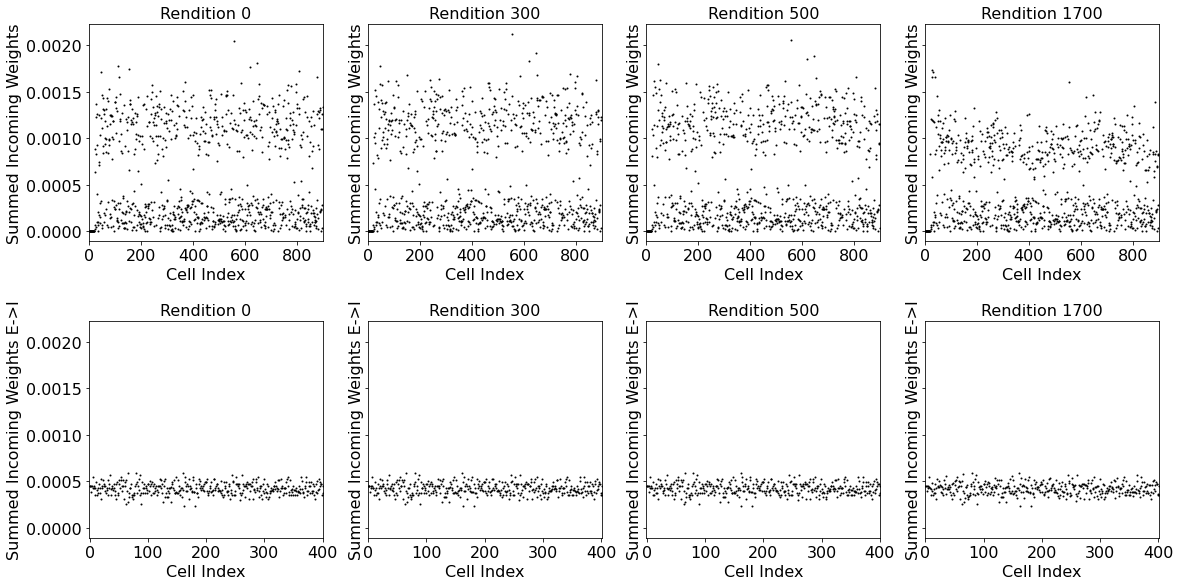

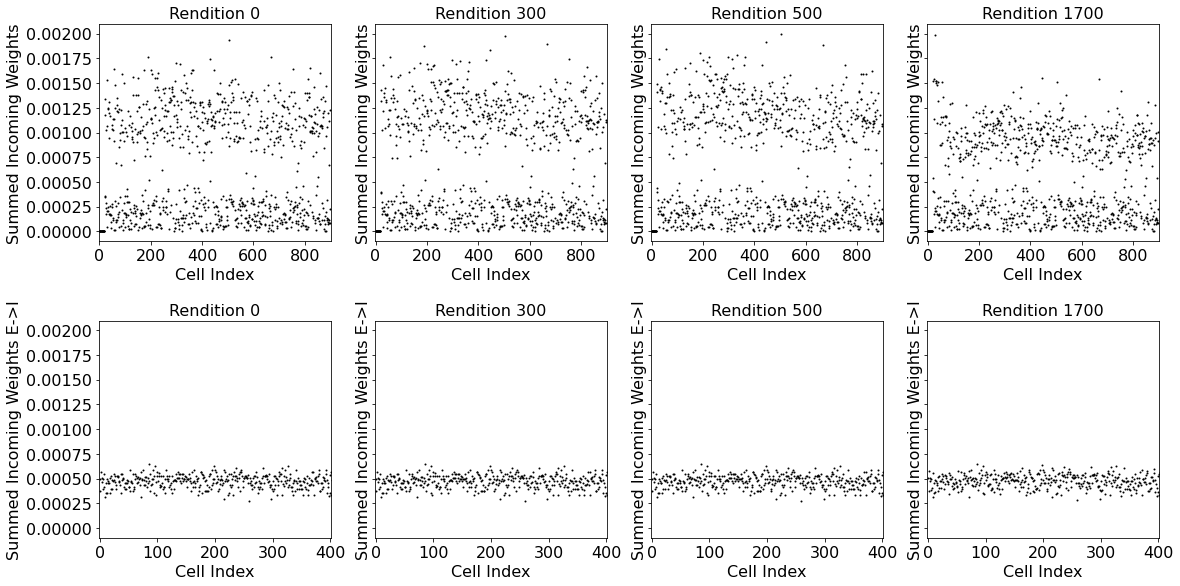

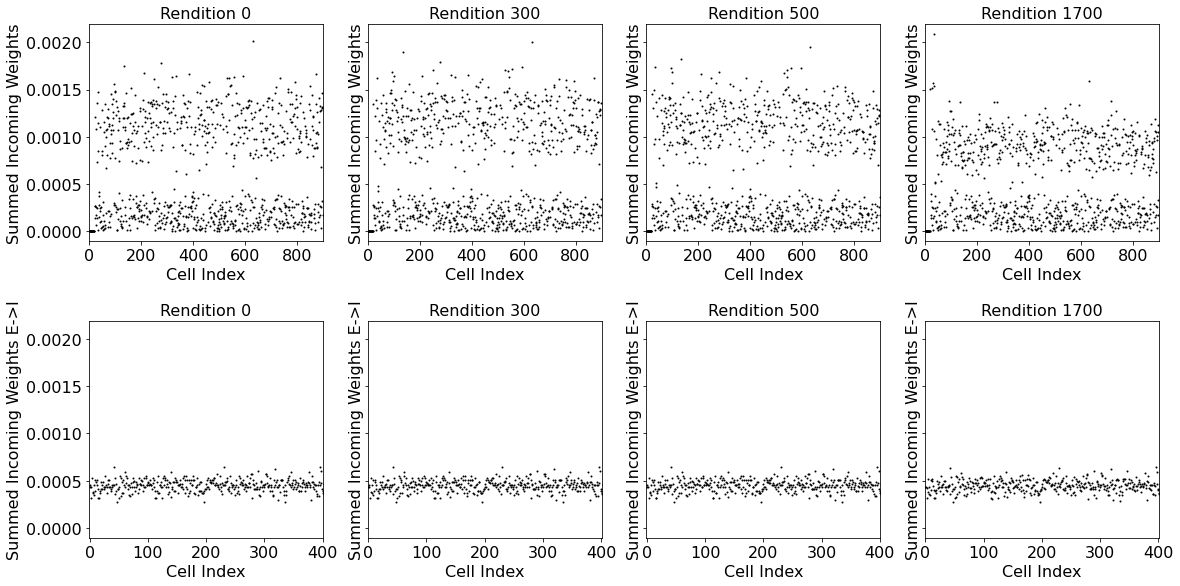

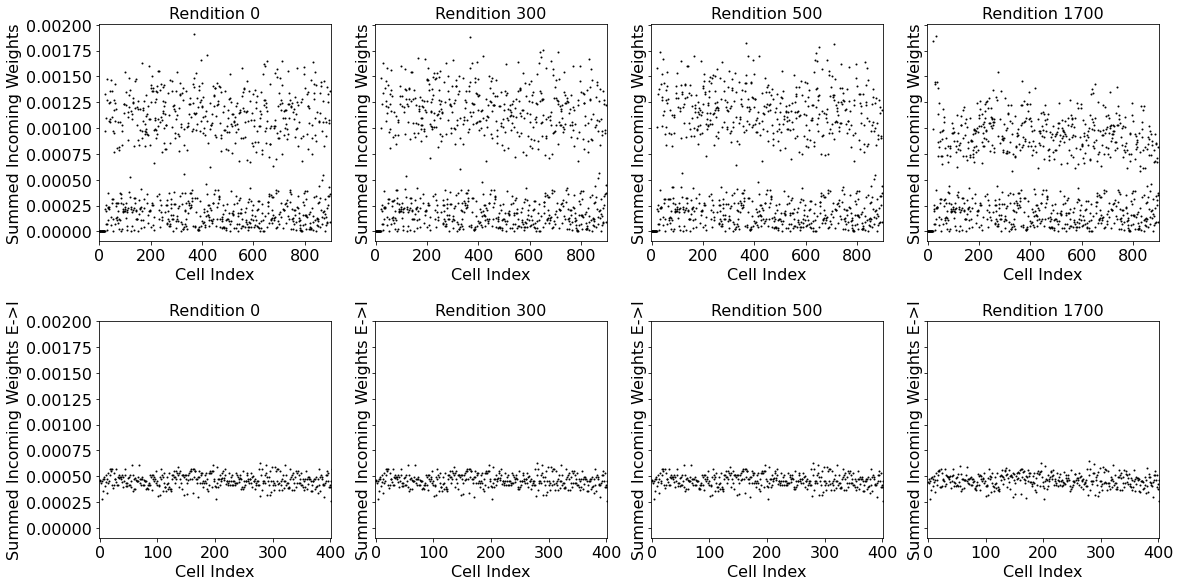

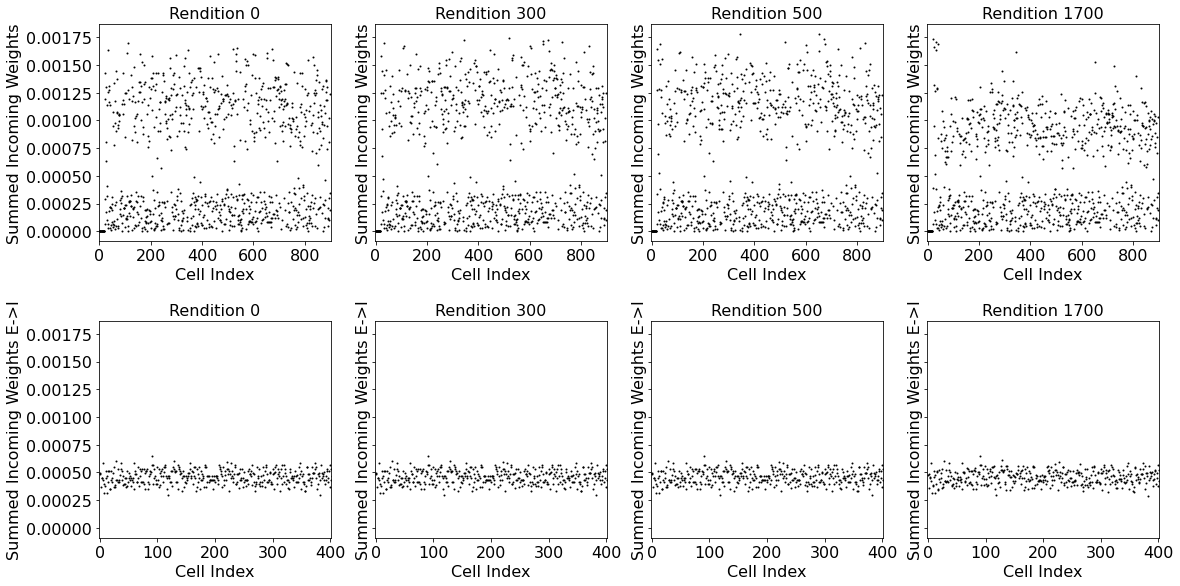

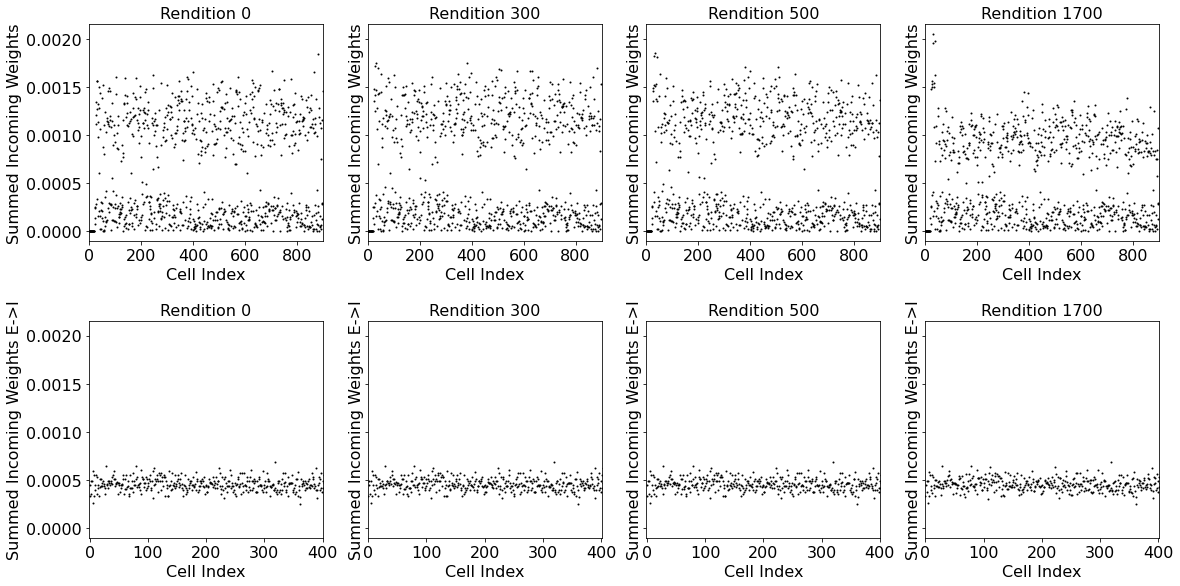

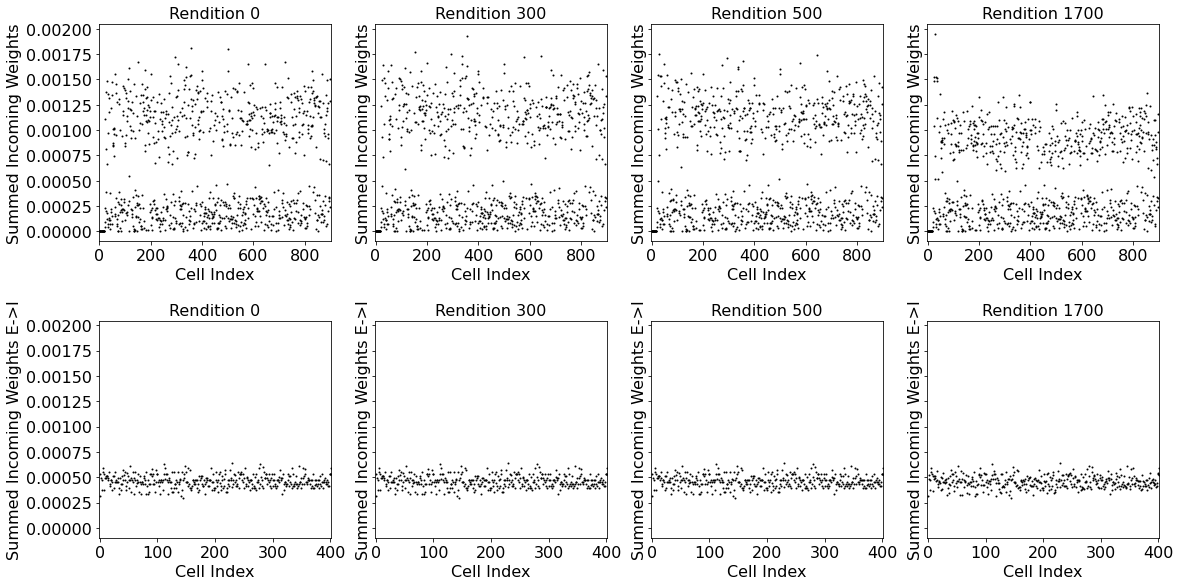

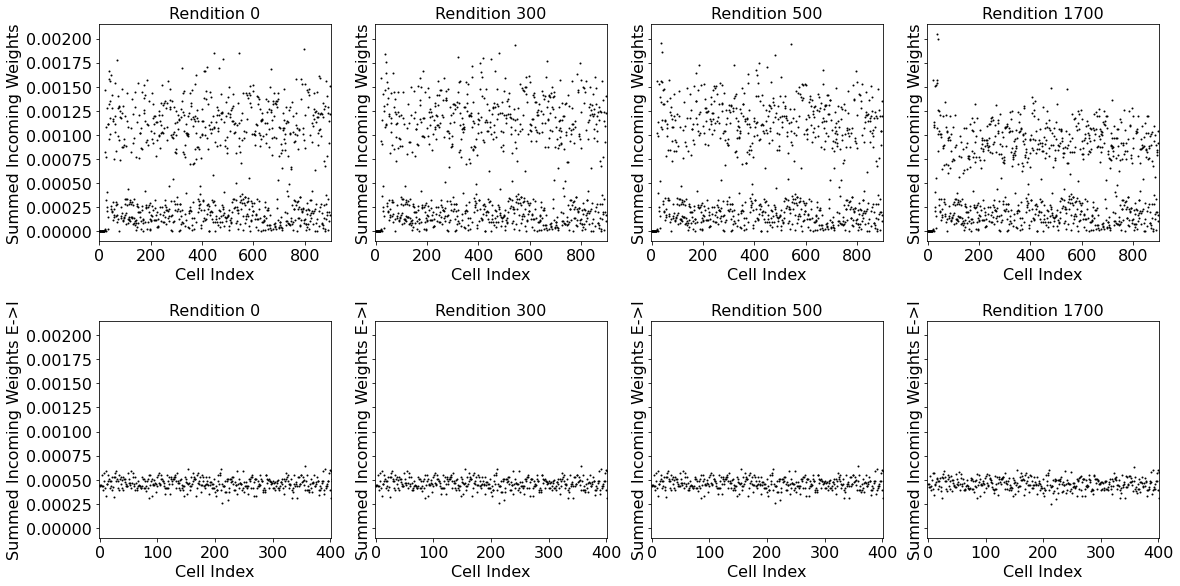

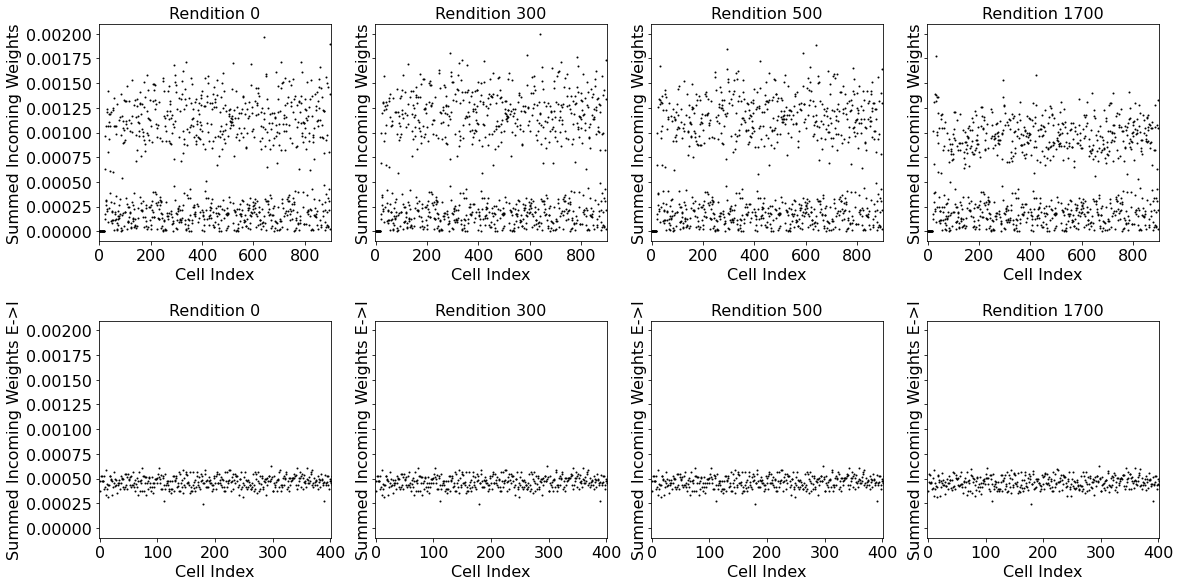

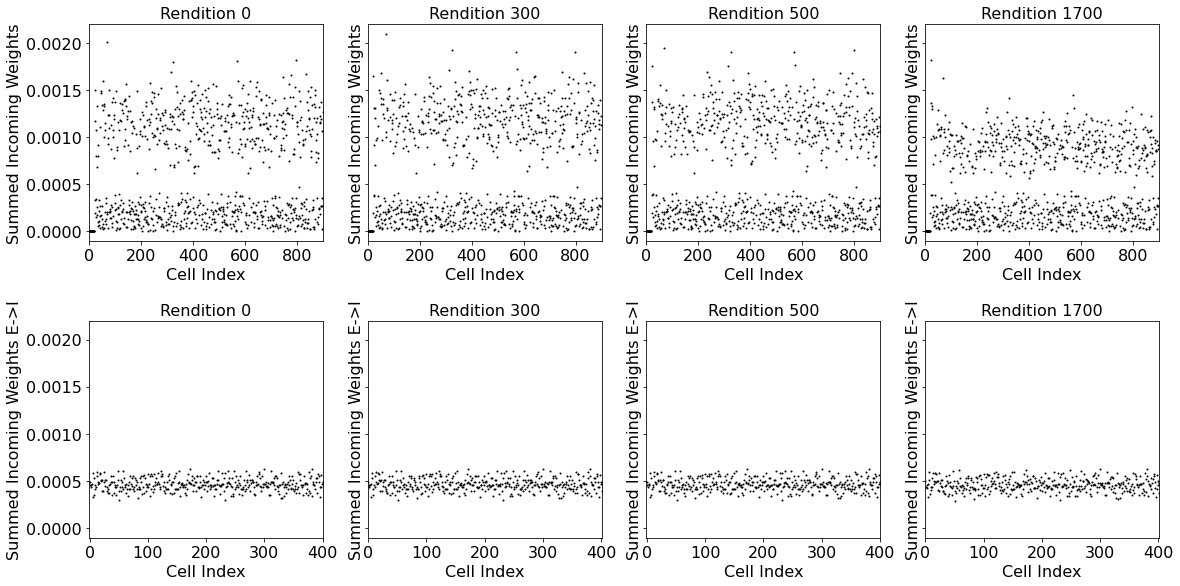

In [18]:
make_figure_5('settle', timepoints=[0, 30, 50, 170])

In [20]:
def make_figure_6(name, timepoints=[0, 50, 100, 150], color='black'):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        scale = 1.1
        fig, axs = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(15 * scale, 7.5 * scale))
        
        timepoint_names = [f'Rendition {t * 10}' for t in timepoints]
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                summed_incoming_weights = data['summed_incoming_weights'].reshape(data['summed_incoming_weights'].shape[1])
                layer_weights = np.array([np.sum(summed_incoming_weights[i:i+20]) for i in range(0, summed_incoming_weights.shape[0], 20)])
                x = np.arange(layer_weights.shape[0])
                
                axs[0, j].scatter(x, layer_weights, s=1, c=color, zorder=0, alpha=1)
                axs[0, j].set_xlim(-1, 46)
                axs[0, j].set_xlabel('Cell Index')
                axs[0, j].set_ylabel('Layer Weights')
                axs[0, j].title.set_text(f'{timepoint_names[j]}')
                
                for idx in range(2):
                    set_font_size(axs[idx, j], 16)
                j += 1
    
        fig.tight_layout()
#         save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')

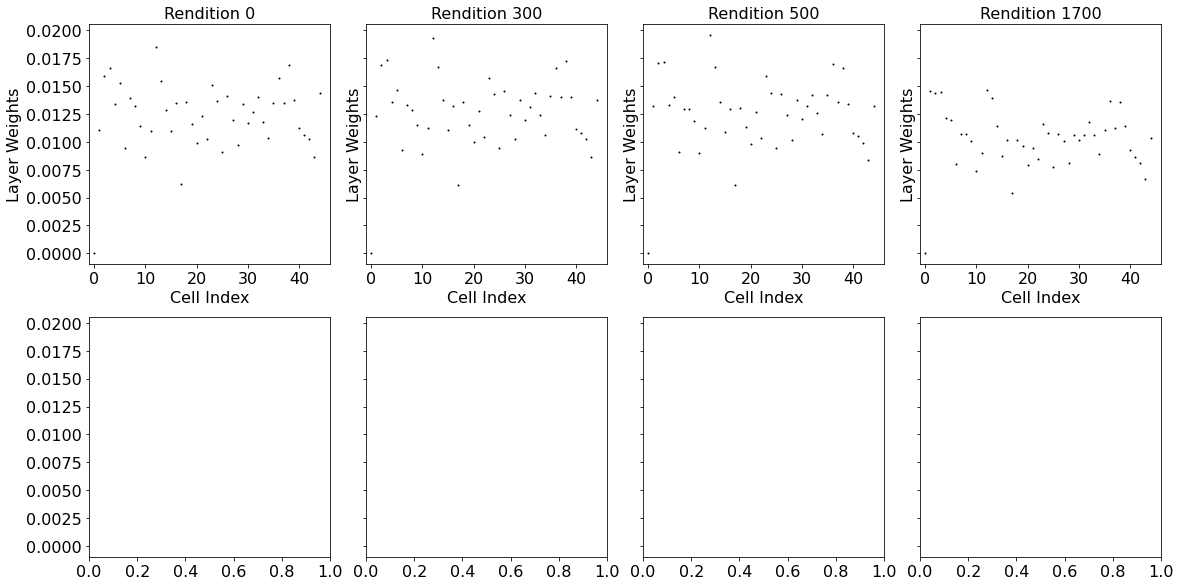

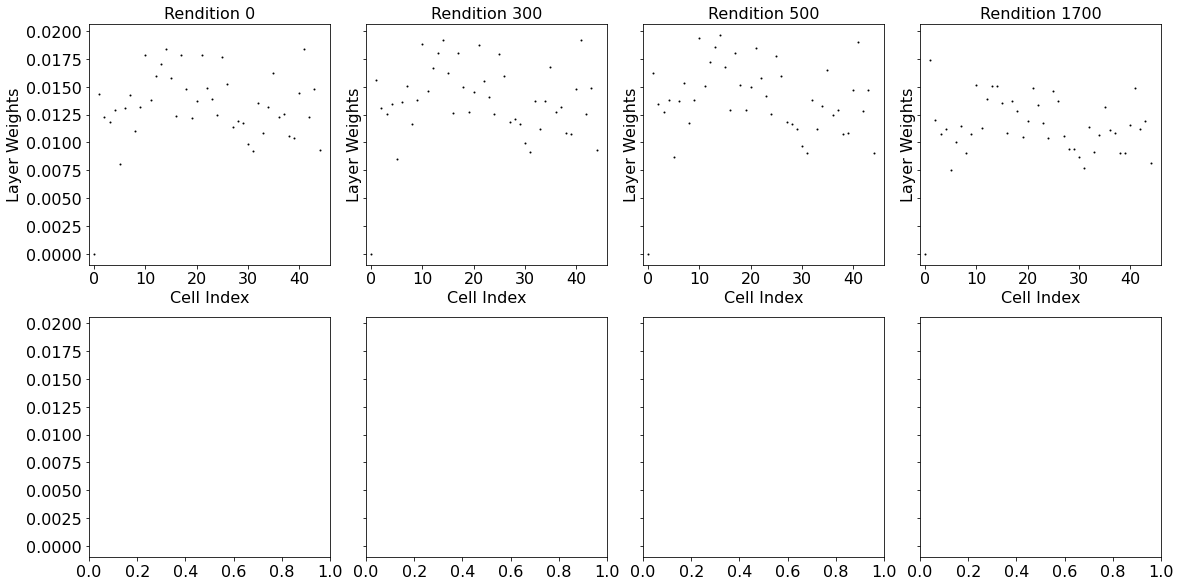

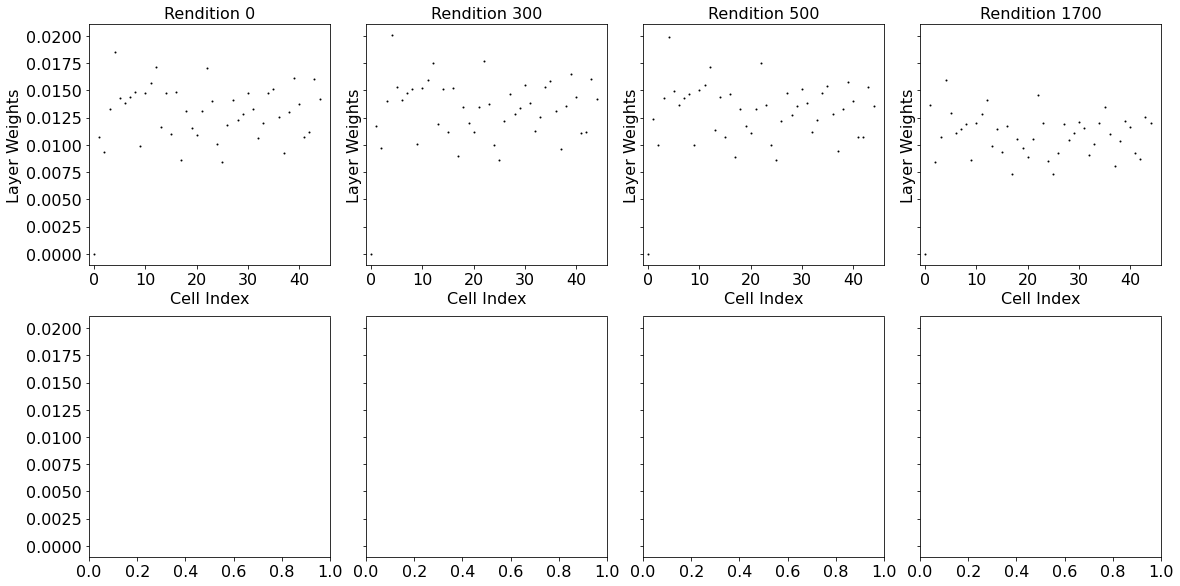

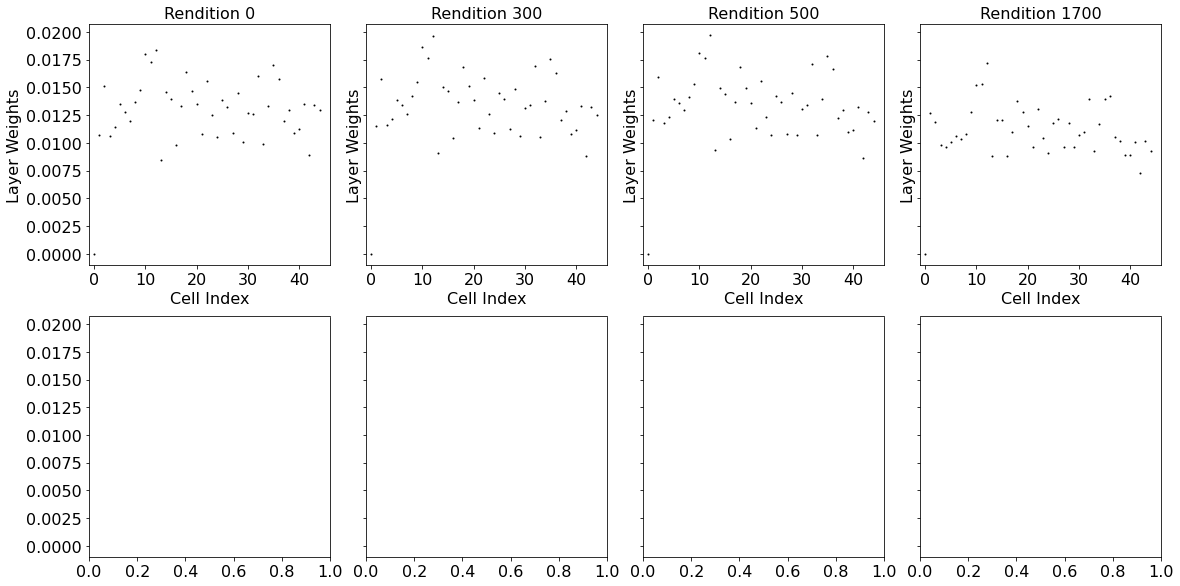

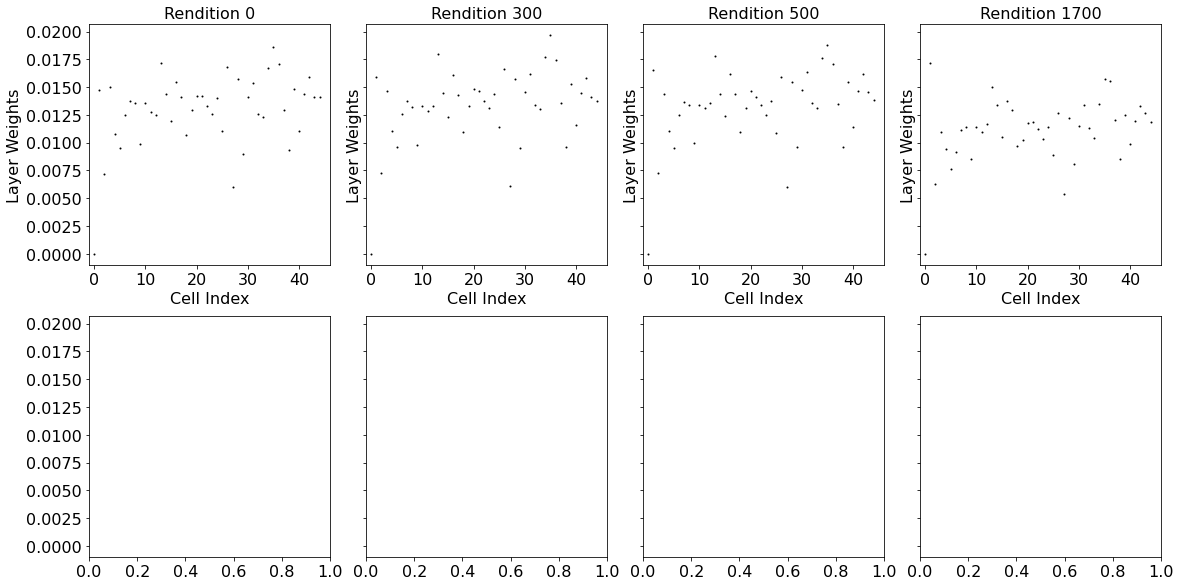

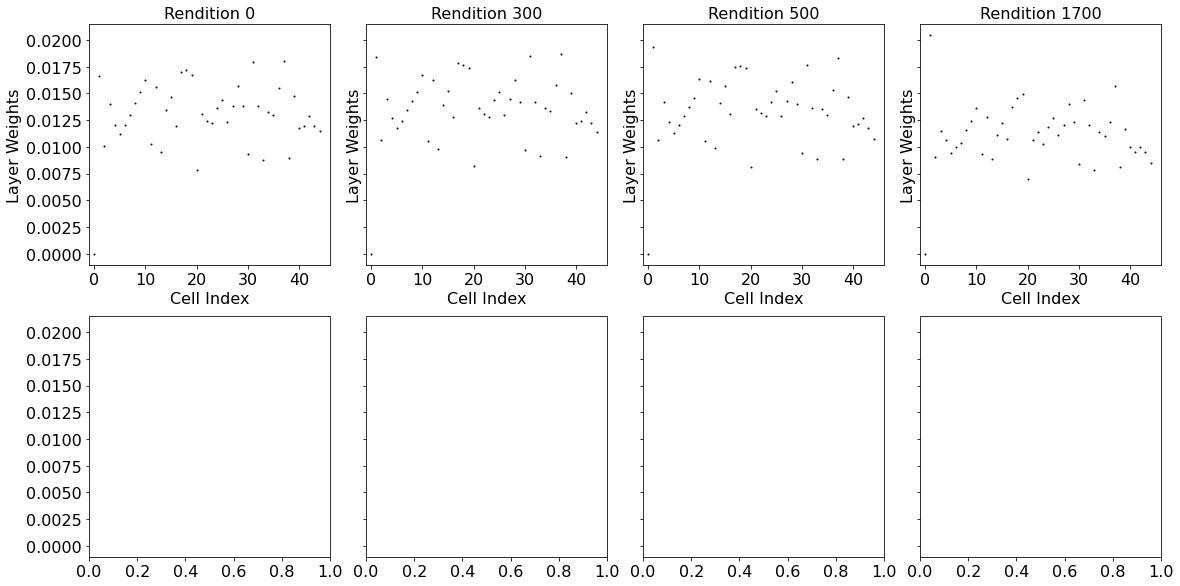

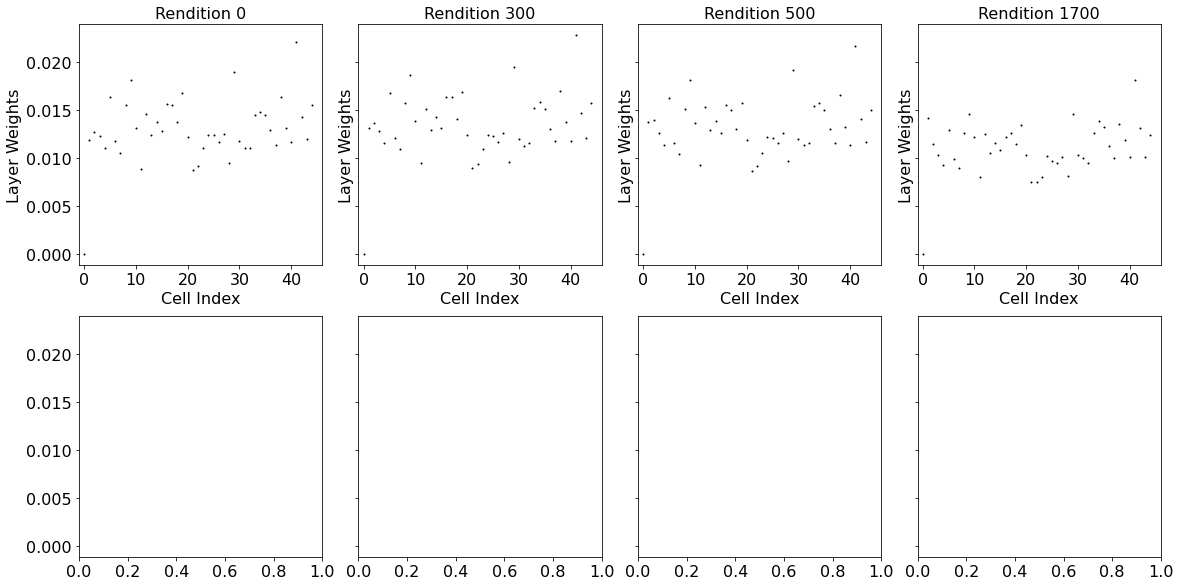

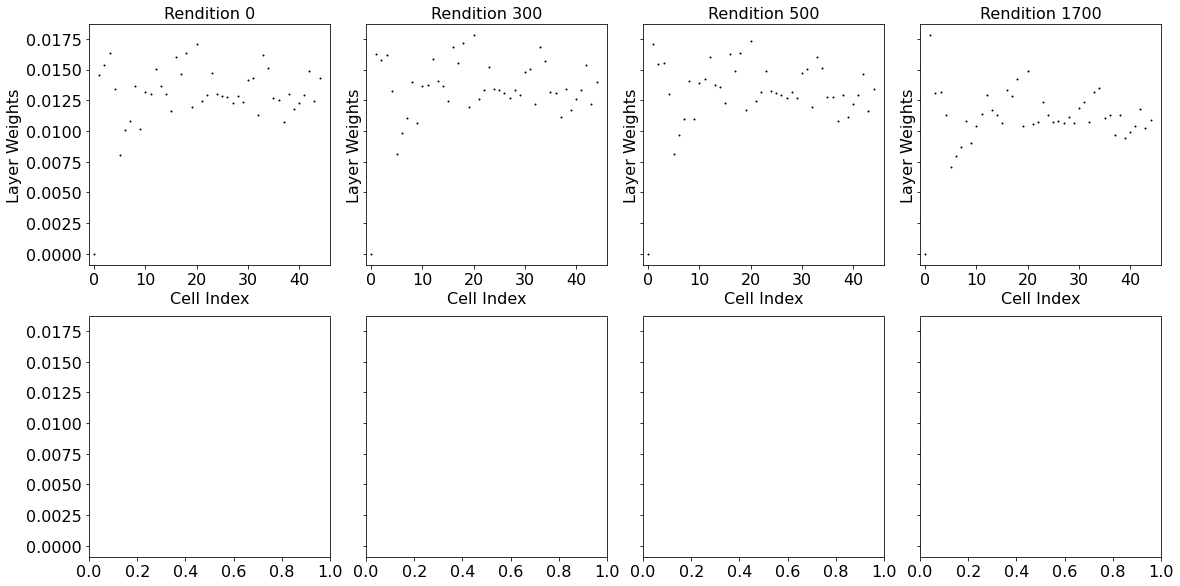

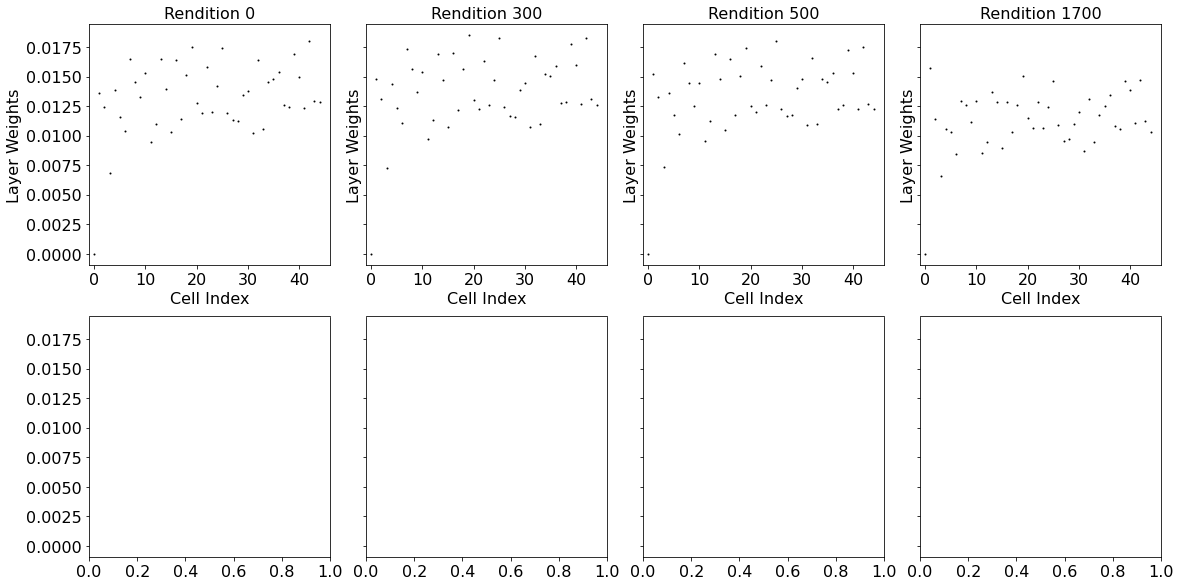

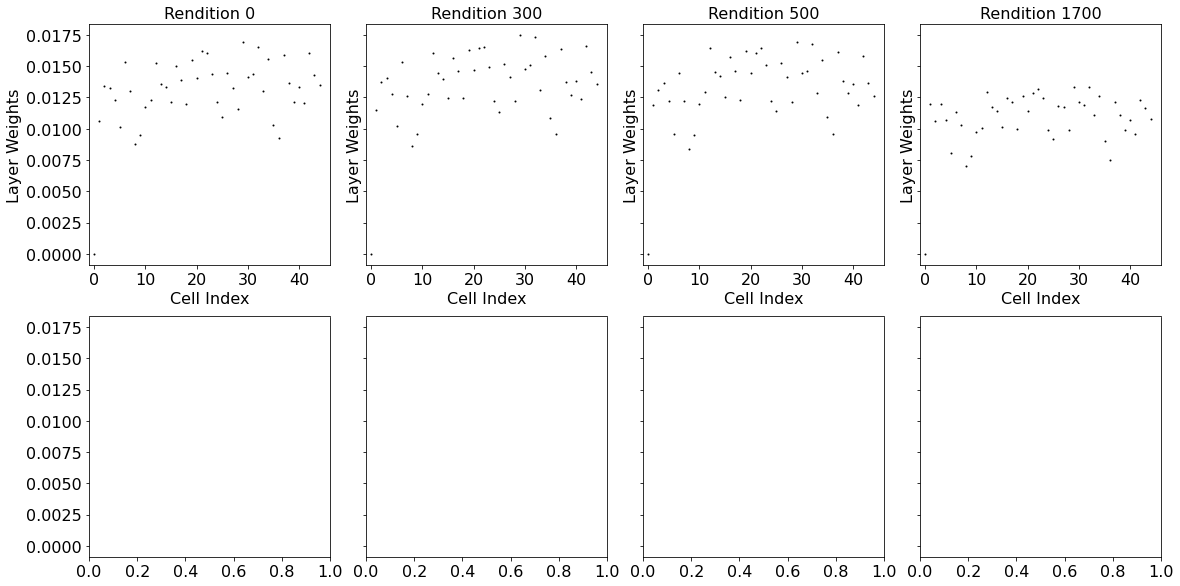

In [21]:
make_figure_6('settle', timepoints=[0, 30, 50, 170])